In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Data types in 'indu' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


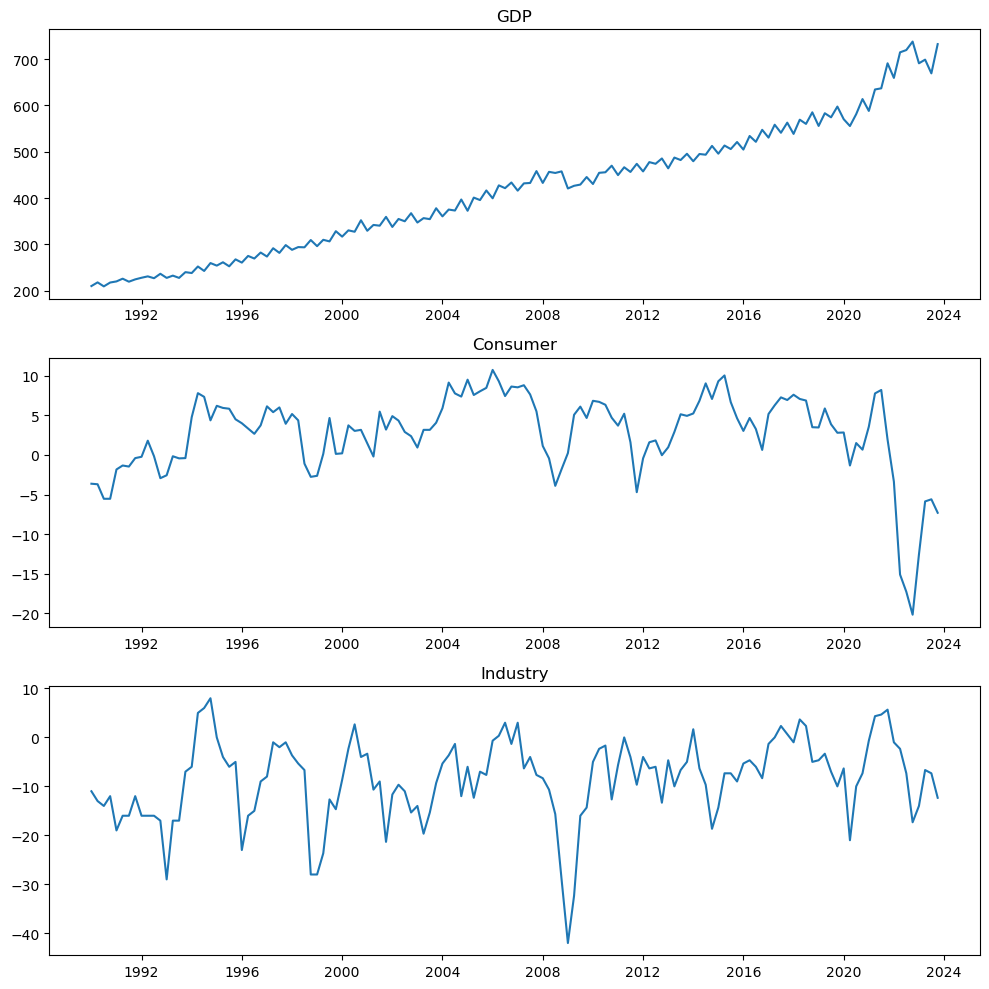

In [3]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

In [4]:
#Using the period 1990-2015 for training and 2016-2020 for testing
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2016-01-01')]
cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2016-01-01')]
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2016-01-01')]

indu_test = indu[(indu['Time'] >= '2016-01-01') & (indu['Time'] < '2020-01-01')]
cons_test = cons[(cons['Time'] >= '2016-01-01') & (cons['Time'] < '2020-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

#Printing the length of the training and testing data
print("indu lenght: ", len(indu_train), " cons lenght: ", len(cons_train)," gdp lenght: ", len(gdp_train))
print("indu lenght: ", len(indu_test), " cons lenght: ", len(cons_test)," gdp lenght: ", len(gdp_test))

#Since gdp is not stationary, we will take the first difference
gdp_train['Value_diff'] = gdp_train['Value'].diff().fillna(0)
gdp_test['Value_diff'] = gdp_test['Value'].diff().fillna(0)

indu lenght:  104  cons lenght:  104  gdp lenght:  104
indu lenght:  16  cons lenght:  16  gdp lenght:  16


In [5]:
#Creating quarterly dummies
quarters = pd.date_range(start='1990-01-01', end='2019-12-31', freq='Q')
quarter_dummies = pd.get_dummies(quarters.quarter, prefix='Quarter')

# Convert the dummies from boolean values to integer
quarter_dummies = quarter_dummies.astype(int)

In [6]:
# Combine the explanatory data into one train dataframe
exog_train = pd.merge(indu_train, cons_train, on='Time')
exog_train = exog_train.drop(['Time'], axis=1)
# Adding the quarterly dummy variables
quarter_dummies_train = quarter_dummies.head(len(exog_train)).copy()
exog_train = pd.merge(exog_train, quarter_dummies_train, left_index=True, right_index=True)

# Combine the explanatory data into one test dataframe
exog_test = pd.merge(indu_test, cons_test, on='Time')
exog_test = exog_test.drop(['Time'], axis=1)
# Adding the quarterly dummy variables
quarter_dummies_test = quarter_dummies.tail(len(exog_test)).copy()
quarter_dummies_test.reset_index(inplace=True, drop=True)  # Reset index and drop the old index
exog_test = pd.merge(exog_test, quarter_dummies_test, left_index=True, right_index=True)

# Reshape input data for LSTM
exog_train_reshaped = exog_train.values.reshape((exog_train.shape[0], 1, exog_train.shape[1]))
exog_test_reshaped = exog_test.values.reshape((exog_test.shape[0], 1, exog_test.shape[1]))

# Extract the essential variables
endog_train = gdp_train['Value_diff'] # Differenced GDP for training
endog_test = gdp_test['Value_diff'] # Differenced GDP for further training contiously in the one step ahead prediction
endog_test_actuals = gdp_test['Value'] # Actual GDP for testing

# Initialize an array to store predictions
y_preds = []

# Define the RNN model
model = Sequential([
    SimpleRNN(units=50, activation='tanh', input_shape=(1, exog_train.shape[1]), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)),
    Dense(units=1, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42))
])

# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# Train the model and predict one step ahead for each observation in the test set
for i in range(len(exog_test_reshaped)):
    # Extract current test data point
    current_exog = exog_test_reshaped[[i]]
    
    # Train the model on both train and test data up until the current period
    train_exog = np.concatenate((exog_train_reshaped, exog_test_reshaped[:i]), axis=0)
    train_endog = pd.concat([endog_train, endog_test.iloc[:i]], axis=0)
    
    # Train the model
    model.fit(train_exog, train_endog, epochs=1, batch_size=32, verbose=0)
    
    # Predict one step ahead
    y_pred = model.predict(current_exog)
    y_preds.append(y_pred)

# Convert the list of predictions to a numpy array
y_preds = np.array(y_preds)

# Reverse the first difference and cumulative sum to get actual values
y_preds_norm = np.cumsum(y_preds) + gdp_test['Value'].iloc[0]

# Calculating the RMSE
rmse_value = rmse(endog_test_actuals, y_preds_norm)
# Calculating the MAPE
mape_value = mean_absolute_percentage_error(endog_test_actuals, y_preds_norm)*100 #Multiplying by 100 to get the percentage

print("The RMSE of the model is:", rmse_value)
print("The MAPE of the model is:", mape_value)

#The RMSE of the model is: 81. The model is not accurate.
#The MAPE is 13,3%.

1/1 [==============================] - 0s 24ms/step
The RMSE of the model is: 80.98864958994389
The MAPE of the model is: 13.318966307231022


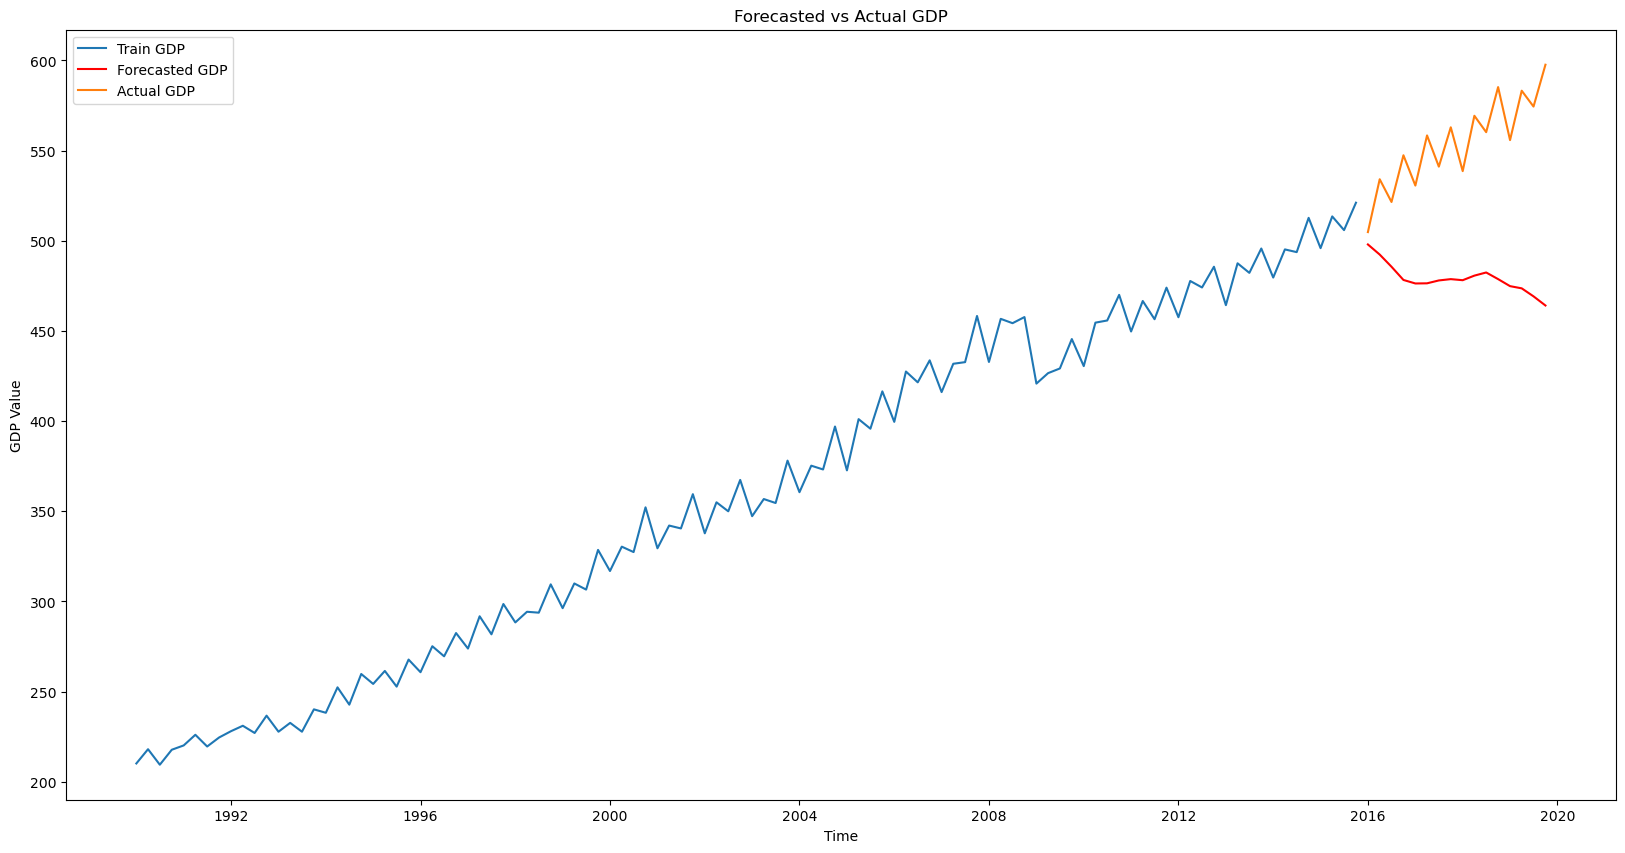

In [7]:
# Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'], gdp_train['Value'], label='Train GDP')
plt.plot(gdp_test['Time'], y_preds_norm, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'], gdp_test['Value'], label='Actual GDP')
plt.xlabel('Time')
plt.ylabel('GDP Value')
plt.title('Forecasted vs Actual GDP')
plt.legend(loc='upper left')
plt.show()

